In [1]:
import glob
import os
import sys
import time
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from model import data_analysis
from plotly.subplots import make_subplots

DATA_PATH = '../data/Data_20200731/someData/'

In [2]:
#FILENAME = 'raw_NISTA001_20200715_024114_GMT.bin.marked.csv.csv'
#FILENAME =  'raw_NISTA052_20200716_193850_GMT.bin.marked.csv.csv'
#FILENAME ='raw_NISTA051_20200716_192656_GMT.bin.marked.csv.csv'
FILENAME = 'raw_NISTA063_20200721_152604_GMT.bin.marked.csv.csv'
# 'raw_NISTA021_20200716_213906_GMT.bin.marked.csv'
# # this data process above assumes a simple <60 dBm filter to set false positive
# 'raw_NISTA014_20200708_014055_GMT.bin.marked.csv.csv'
# 'raw_NISTA001_20200715_024114_GMT.bin.marked.csv.csv'

#df = data_analysis.load_marked(os.path.join(DATA_PATH, FILENAME))
#df.head()

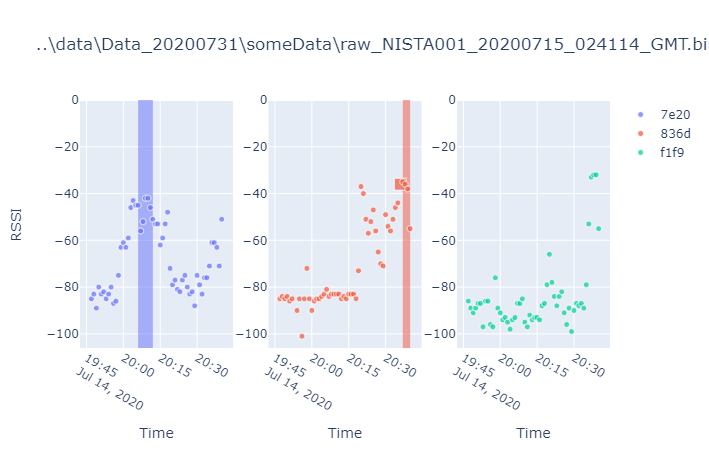

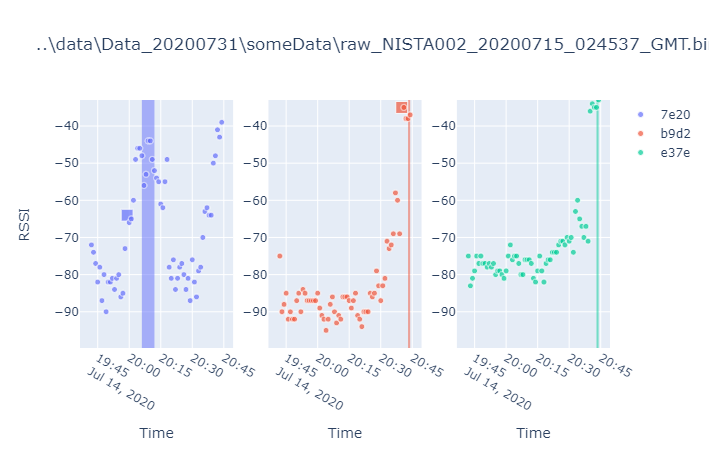

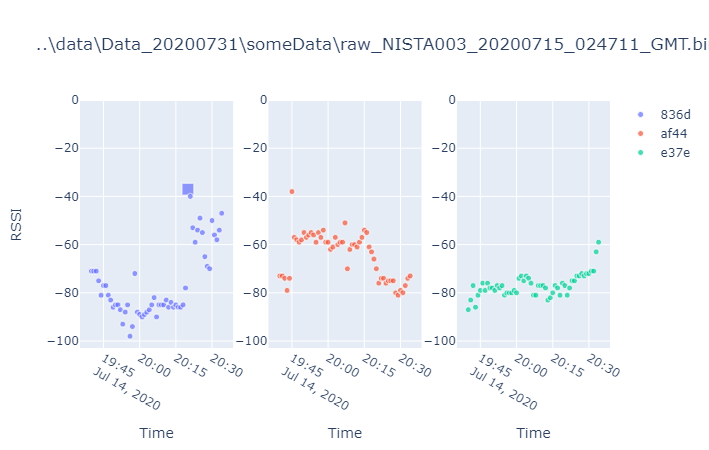

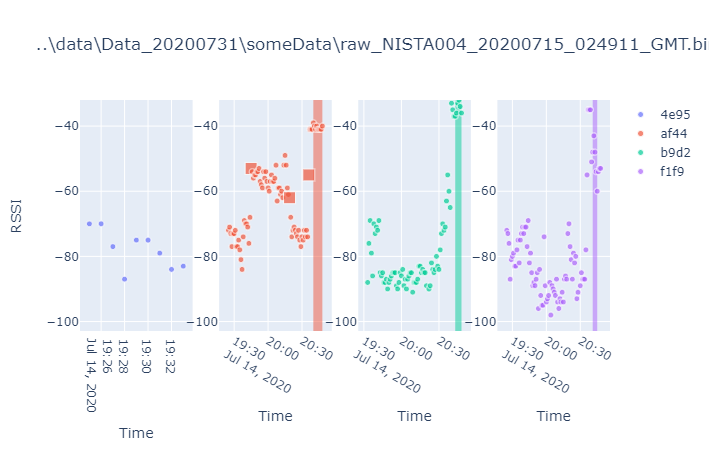

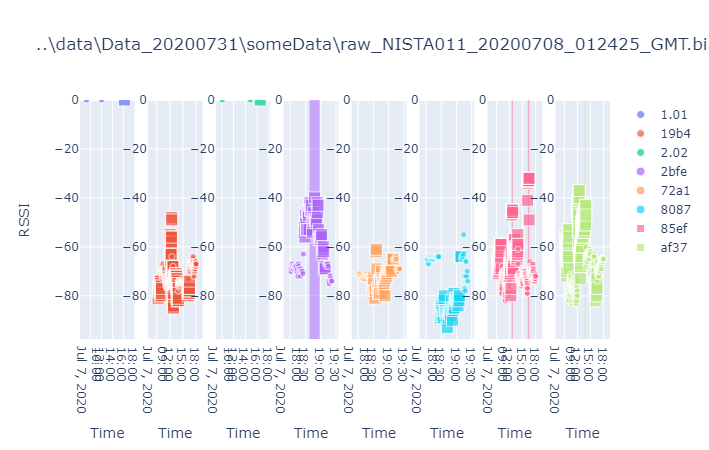

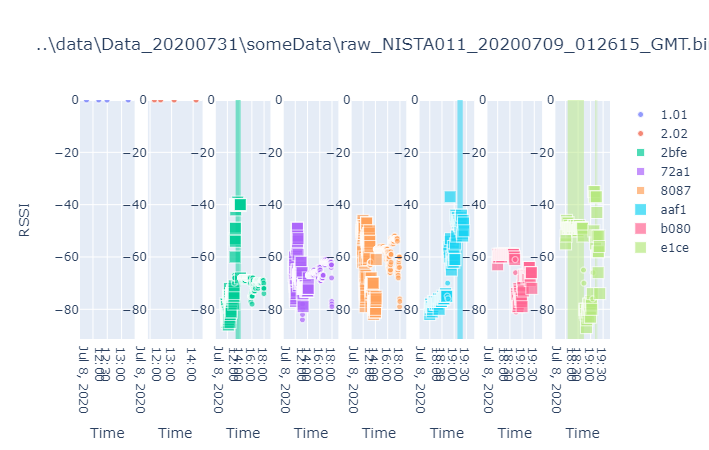

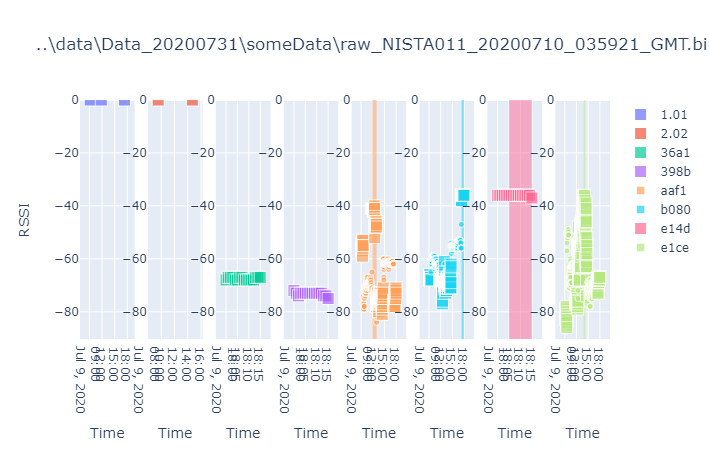

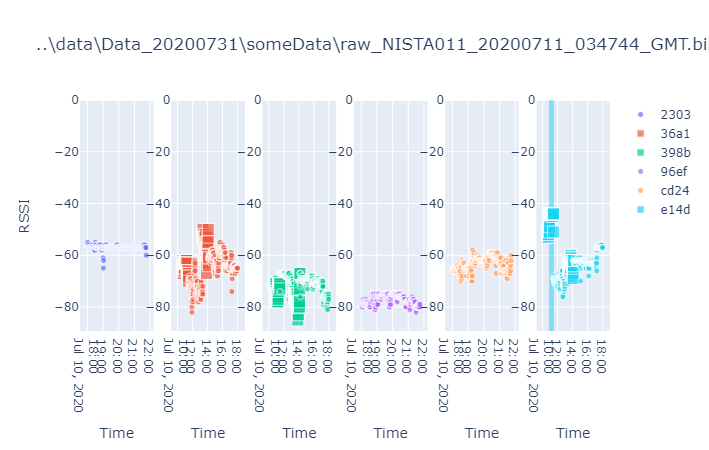

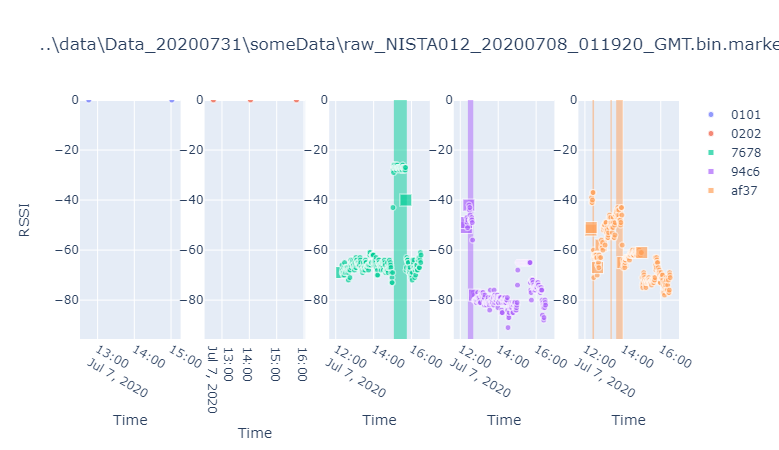

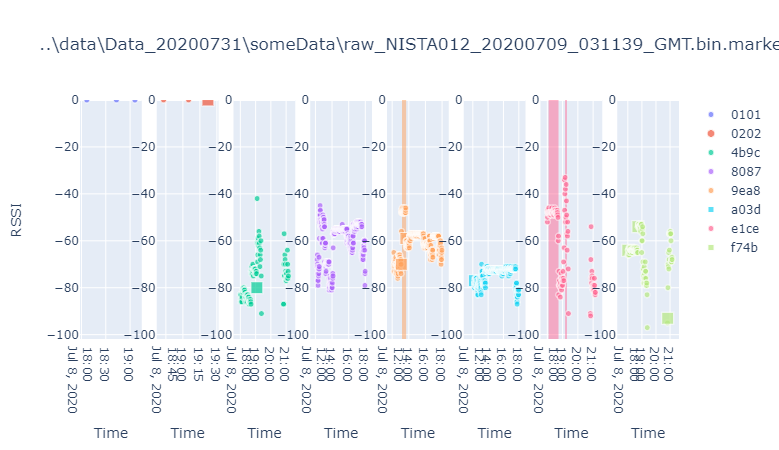

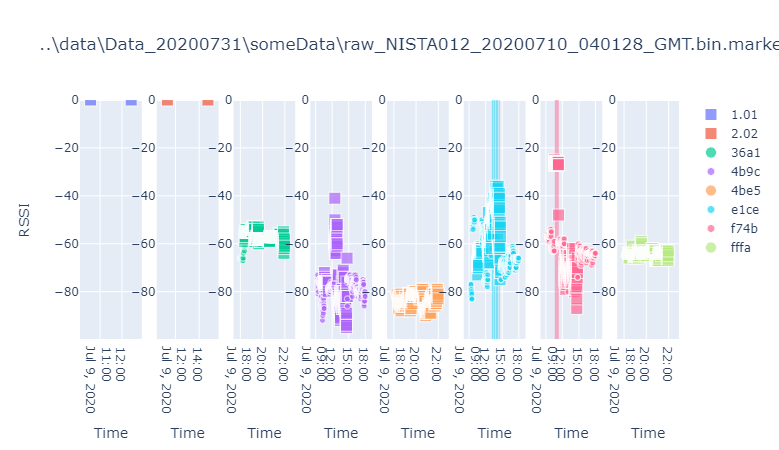

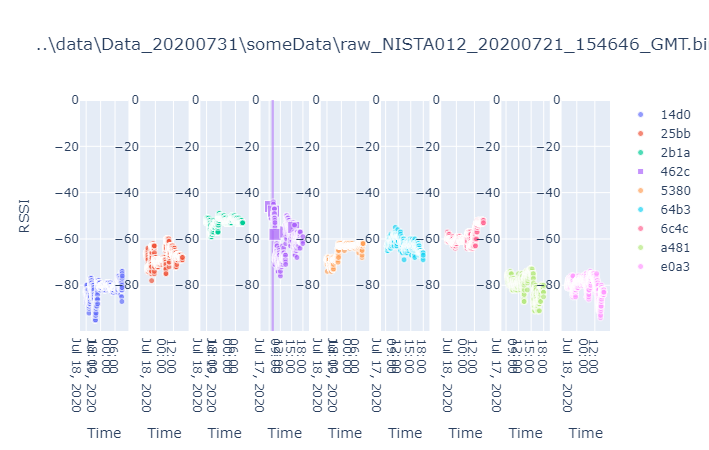

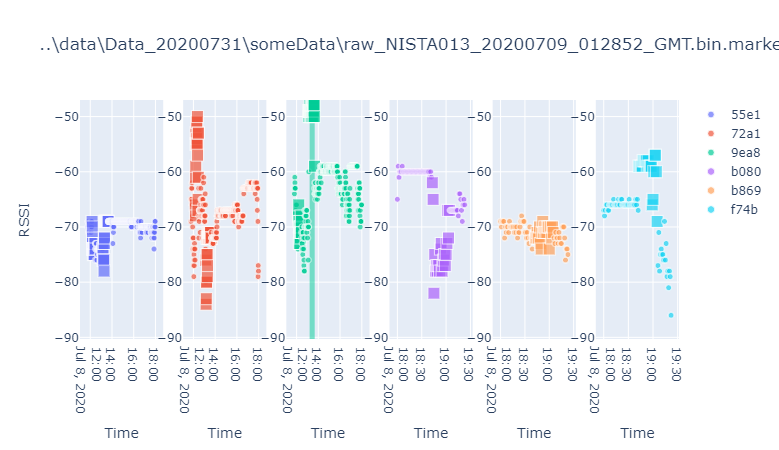

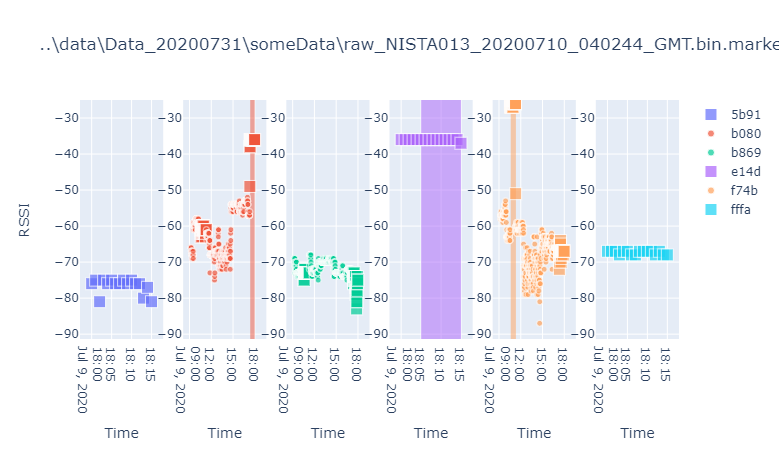

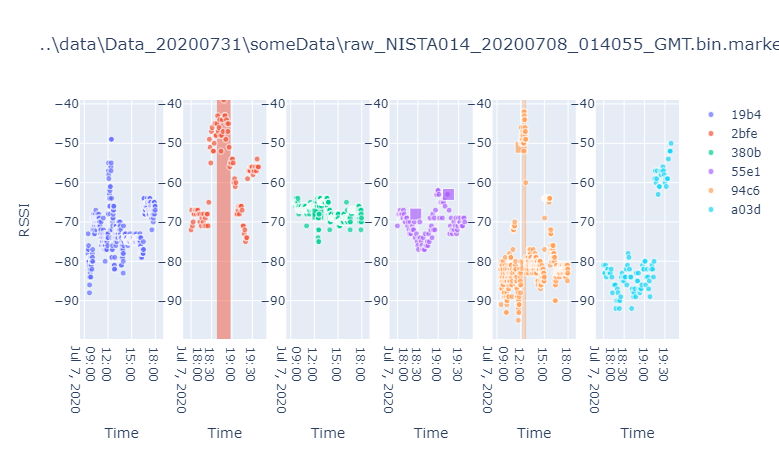

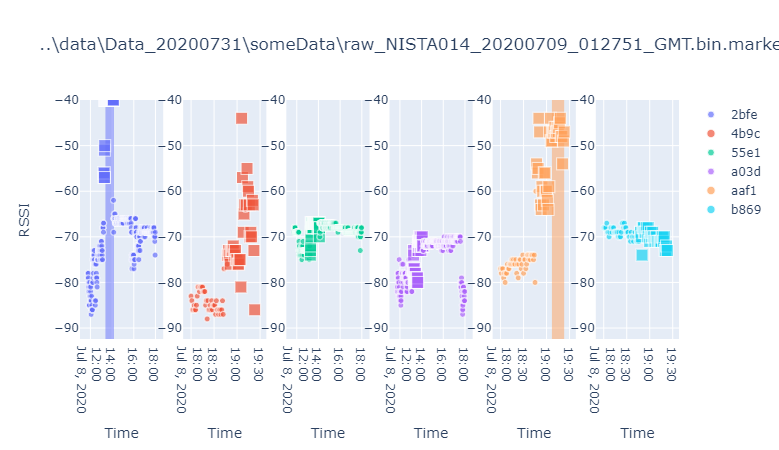

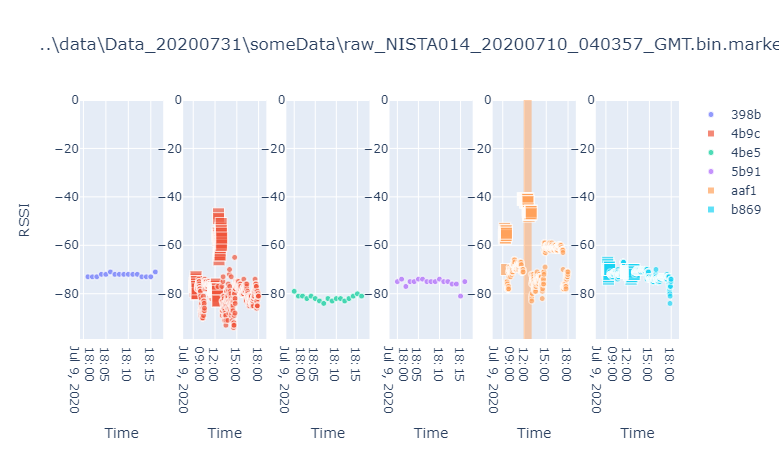

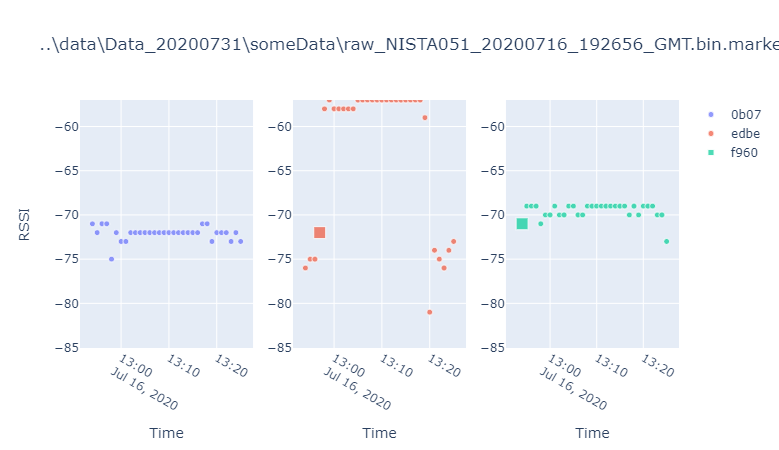

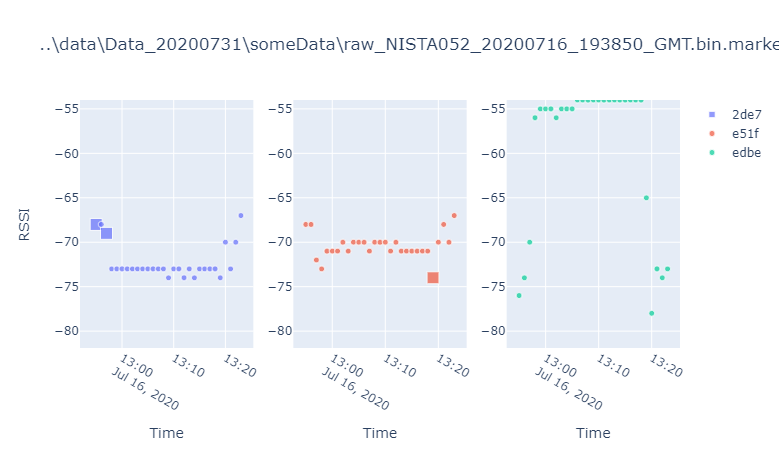

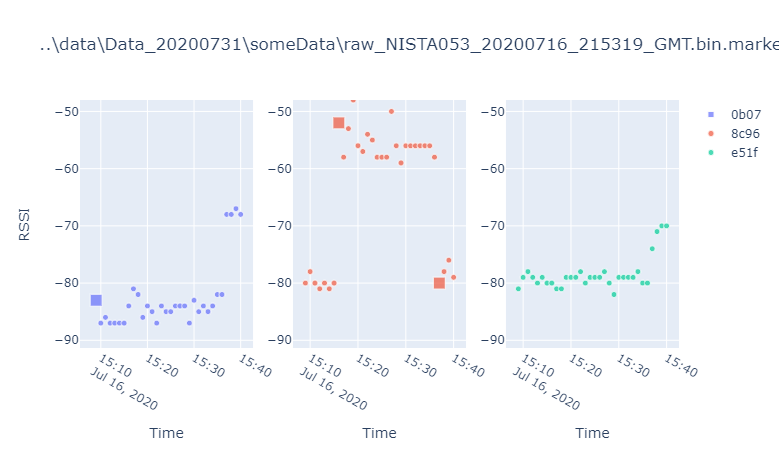

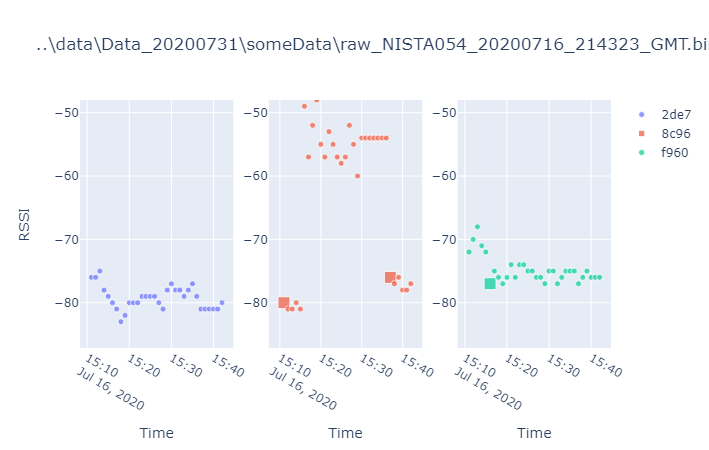

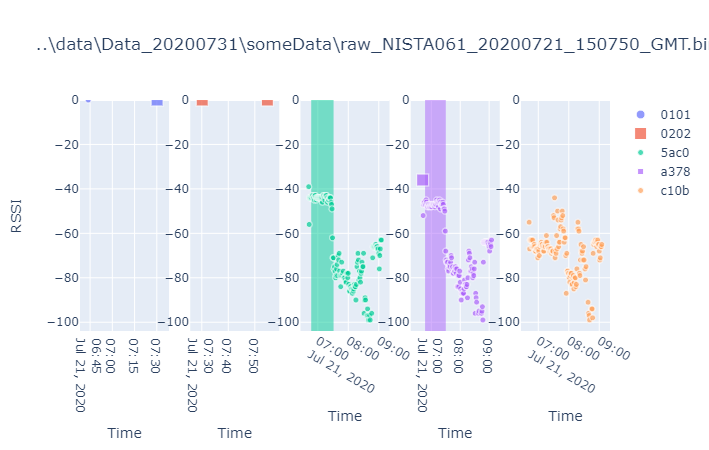

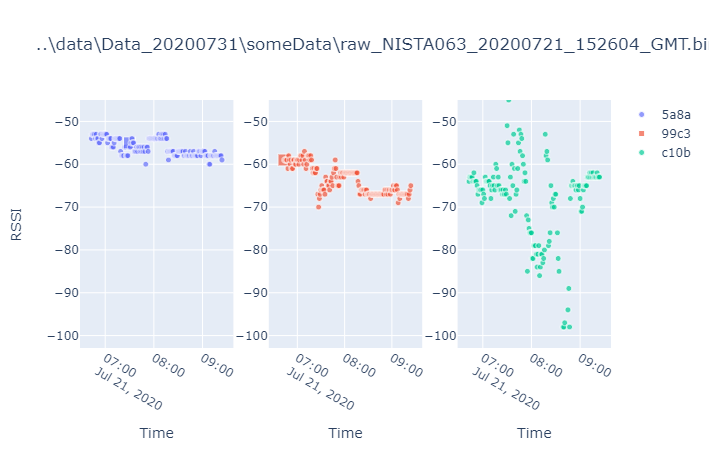

In [7]:
p = pathlib.Path(DATA_PATH)
for one_item in p.glob('*.marked.csv.csv'):
  #  print(f"{one_item}: {type(one_item)}")
    df = data_analysis.load_marked(one_item)
    df.head()
  
    [unique_ids,unique_counts] = data_analysis.get_unique(df)
    
    if (df['close encounter']).notnull().values.any():
        WINDOW_SIZE = 6
        REQD_READINGS = 4
        CLOSE_LEVEL = -50
        # default value is -60

        fig = make_subplots(rows=1, cols=len(unique_ids[unique_counts>1])) #, shared_yaxes=True
        ylim0 = 1.05*min(df['rssi'])
        ylim1 = max(df['rssi'])
        fig.update_xaxes(title_text = "Time")
        fig.update_yaxes(title_text = "RSSI", row=1, col=1)
        fig.update_yaxes(range=[ylim0, ylim1])
        figcolors = px.colors.qualitative.Plotly

        for eid in range(len(unique_ids[unique_counts>1])):
            df_eid = df[df['encounter_id'] == unique_ids[unique_counts>1][eid]].copy()
            df_eid = data_analysis.mofn_filter(df_eid, WINDOW_SIZE, REQD_READINGS, CLOSE_LEVEL)
            df_eid.set_index('time', inplace=True)
            df_eid['comment_index'] = pd.notna(df_eid['close encounter'])

            transitions = data_analysis.transitions(df_eid)

        #     print(transitions)

            plot_index = eid+1

            for i in range (0, len(transitions), 2):
                fig.add_trace(go.Scatter(x=[transitions[i], transitions[i], transitions[i+1], transitions[i+1], transitions[i]], 
                                         y=[ylim0, ylim1, ylim1, ylim0, ylim0], mode="lines",
                                         fill="toself",line_width=0, fillcolor=figcolors[eid], opacity = 0.5, showlegend=False),
                             row=1, col=plot_index)
        #         or use fillcolor = 'MediumPurple'

            df_eid.loc[df_eid['close encounter'].isin(['NO','FALSE POSITIVE']), 'symbol'] = 5 # triangle up if no or false positive
            df_eid.loc[(df_eid['close encounter'].isnull())|(df_eid['close encounter']=='YES'), 'symbol'] = 0 # circle if NaN or YES
            df_eid.loc[df_eid['symbol'].isnull(),'symbol'] = 1 # square if I haven't defined symbol in prev 2 lines
            df_eid.loc[df_eid['symbol']==1,'markersize'] = 12 # bigger square
            df_eid.loc[df_eid['markersize'].isnull(),'markersize'] = 6 #the non-square markers are size six

            fig.add_trace(go.Scatter(x=df_eid.index, y=df_eid.rssi, 
                                     mode="markers", marker_color=figcolors[eid], 
                                     marker_symbol=df_eid['symbol'], marker_size=df_eid['markersize'],
                                     name = df_eid.encounter_id[1][:4], text=df_eid["close encounter"]), 
                          row=1, col=plot_index)


            del df_eid

          # ADD TITLE TO PLOT WITH NAME OF FILE
        fig.update_layout(title=str(one_item))
        fig.show()

        # DONE change marker type based on 'close encounter' text
        # e.g. square if comment other than NaN, NO, YES, FALSE POSITIVE
        # e.g. triangle if comment NO, FALSE POSITIVE
        # e.g. circle if NaN, YES
      

In [4]:
df['close encounter'].notnull().values.any()

True